Source of data
<https://nces.ed.gov/programs/digest/d23/tables/dt23_219.46.asp>

In [1]:
import pandas as pd
import numpy as np

#stuff for plotting states
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Polygon
import missingno as msno
import os
import openpyxl
import math

In [2]:
df = pd.read_excel('../data/graduation_percentage_2011-2022_.xlsx')
df = df.drop(index=[0,2,3,4])

pattern = r'^\d{4}-\n\d{2}$'

columns_to_keep = [0]
column_names = ['Region']

for col in range(1, df.shape[1]):
    if df.iloc[0, col] and pd.Series(df.iloc[0, col]).astype(str).str.match(pattern).any():
        columns_to_keep.append(col)
        column_names.append(df.iloc[0, col])

df = df.iloc[1:, columns_to_keep]
df.columns = column_names

df.index = np.arange(1, len(df) + 1)
df = df.iloc[:52]
df['Region'] = df['Region'].replace(r'Alabama\\12\\', 'Alabama', regex=True)
df.head(60)

,Region,2011-\n12,2012-\n13,2014-\n15,2015-\n16,2016-\n17,2017-\n18,2019-\n20,2020-\n21,2021-\n22
1,United States,80,81.4,83.2,84.1,84.6,85.3,86.5,86.1,86.6
2,Alabama,75,80,89.3,87.1,89.3,90,90.6,90.7,88.2
3,Alaska,70,71.8,75.6,76.1,78.2,78.5,79.1,78.2,77.8
4,Arizona,76,75.1,77.4,79.5,78,78.7,77.3,76.4,77.3
5,Arkansas,84,84.9,84.9,87,88,89.2,88.8,88.4,88.2
6,California,79,80.4,82,83,82.7,83,84.3,83.6,87
7,Colorado,75,76.9,77.3,78.9,79.1,80.8,81.9,81.7,82.3
8,Connecticut,85,85.5,87.2,87.4,87.9,88.4,88.3,89.6,88.9
9,Delaware,80,80.4,85.6,85.5,86.9,86.9,89,80.5,87.8
10,District of Columbia,59,62.3,68.5,69.2,73.2,68.5,73,74.8,76.4


In [3]:
gdf = gpd.read_file('../data/state_shape')
gdf.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


In [4]:
import re

def parse_year_string(year_string):
    pattern = r'^\d{4}-\n(\d{2})$'
    match = re.match(pattern, year_string)
    
    if match:
        year = year_string[:4]
        two_digit_year = match.group(1)
        if two_digit_year:
            full_year = f"20{two_digit_year}"  # Convert to full year
            return f"{year}-{full_year}"
    return None

def makeColorColumn(gdf,variable,vmin,vmax,colormap):
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=colormap)
    gdf['value_determined_color'] = gdf[variable].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
    return gdf

In [5]:
def gen_map(year_selection, gdf):
    colormap=plt.cm.viridis
    year_df = df[['Region', year_selection]].copy()
    year_df['Region'] = year_df['Region'].str.strip()
    year_df[year_selection] = pd.to_numeric(year_df[year_selection], errors='coerce')
    gdf = gdf.merge(year_df,left_on='NAME',right_on='Region')
    vmin, vmax = gdf[year_selection].min(), gdf[year_selection].max()
    gdf = makeColorColumn(gdf,year_selection,vmin,vmax,colormap)
    
    visframe = gdf.to_crs('EPSG:2163')
    
    fig, ax = plt.subplots(1, figsize=(18, 14))
    ax.set_title('Graduation Percentage by States ' + parse_year_string(year_selection), fontdict={'fontsize': '42', 'fontweight' : '1'})
    ax.axis('off')
    
    fig = ax.get_figure() 
    
    for row in visframe.itertuples():
        if row.STUSPS not in ['AK','HI']:
            vf = visframe[visframe.STUSPS==row.STUSPS]
            c = gdf[gdf.STUSPS==row.STUSPS][0:1].value_determined_color.item()
            vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor='1')
    
    # add Alaska
    akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
    akax.axis('off')
    polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
    alaska_gdf = gdf[gdf.STUSPS=='AK']
    alaska_gdf.clip(polygon).plot(color=gdf[gdf.STUSPS=='AK'].value_determined_color, linewidth=0.8,ax=akax, edgecolor='1')
    
    
    # add Hawaii
    hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
    hiax.axis('off')
    hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
    hawaii_gdf = gdf[gdf.STUSPS=='HI']
    hawaii_gdf.clip(hipolygon).plot(color=hawaii_gdf['value_determined_color'], linewidth=0.8,ax=hiax, edgecolor='1')
    
    fig = ax.get_figure()
    cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31]) 
    cbax.set_title('Pure black means no data.')
    sm = plt.cm.ScalarMappable(cmap=colormap, \
                     norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    comma_fmt = FuncFormatter(lambda x, p: format(x/100, '.0%'))
    fig.colorbar(sm, cax=cbax, format=comma_fmt)
    tick_font_size = 16
    cbax.tick_params(labelsize=tick_font_size)

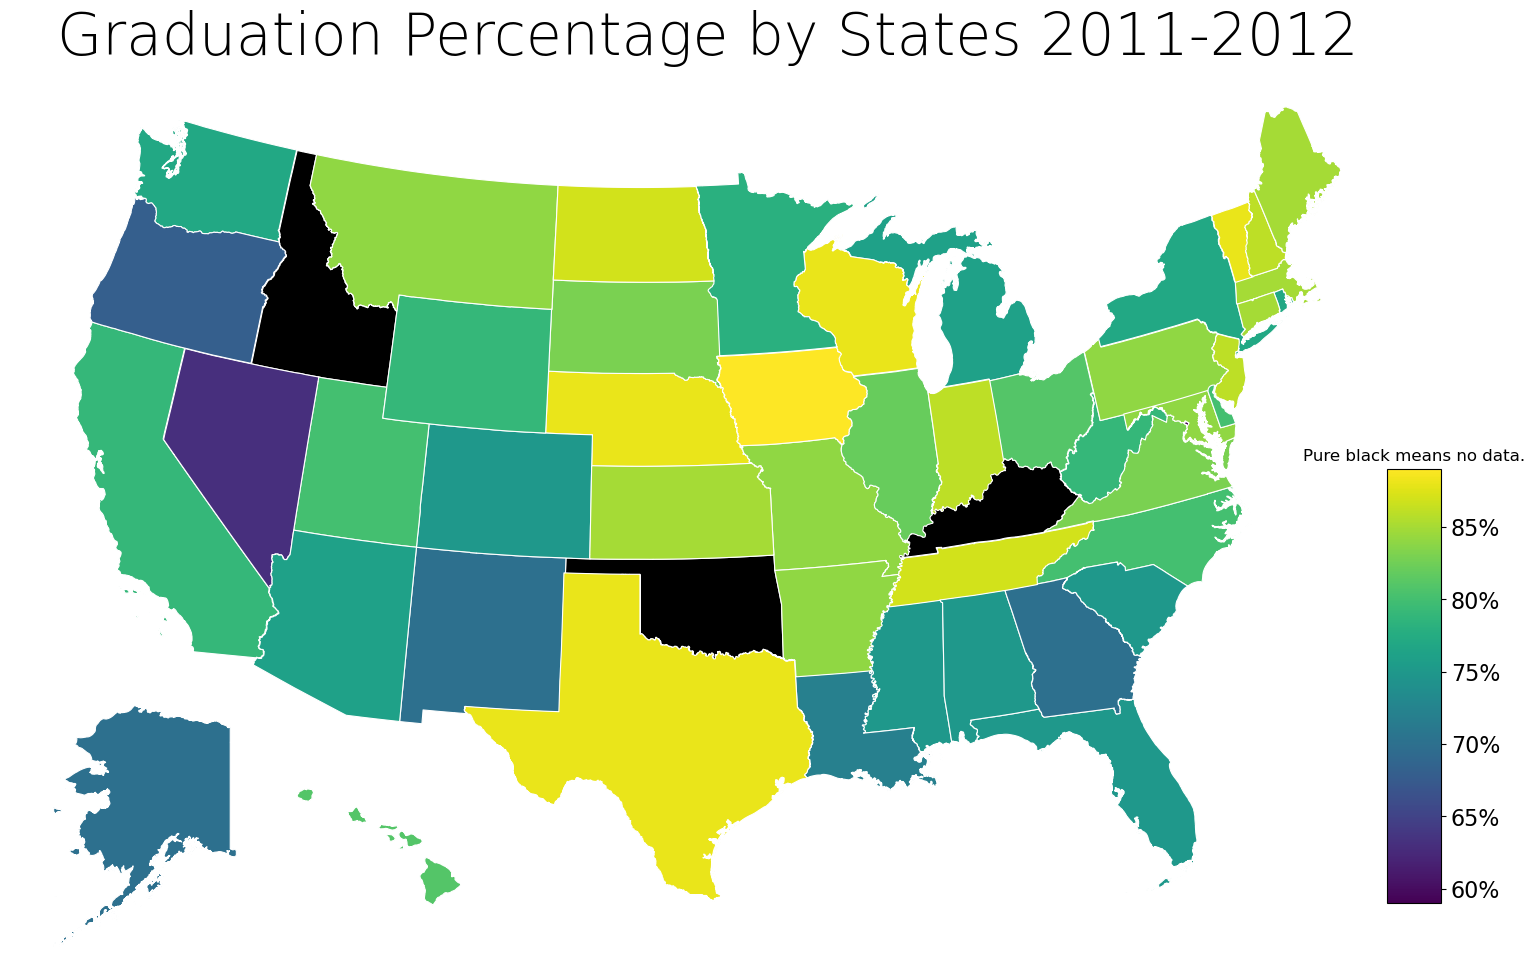

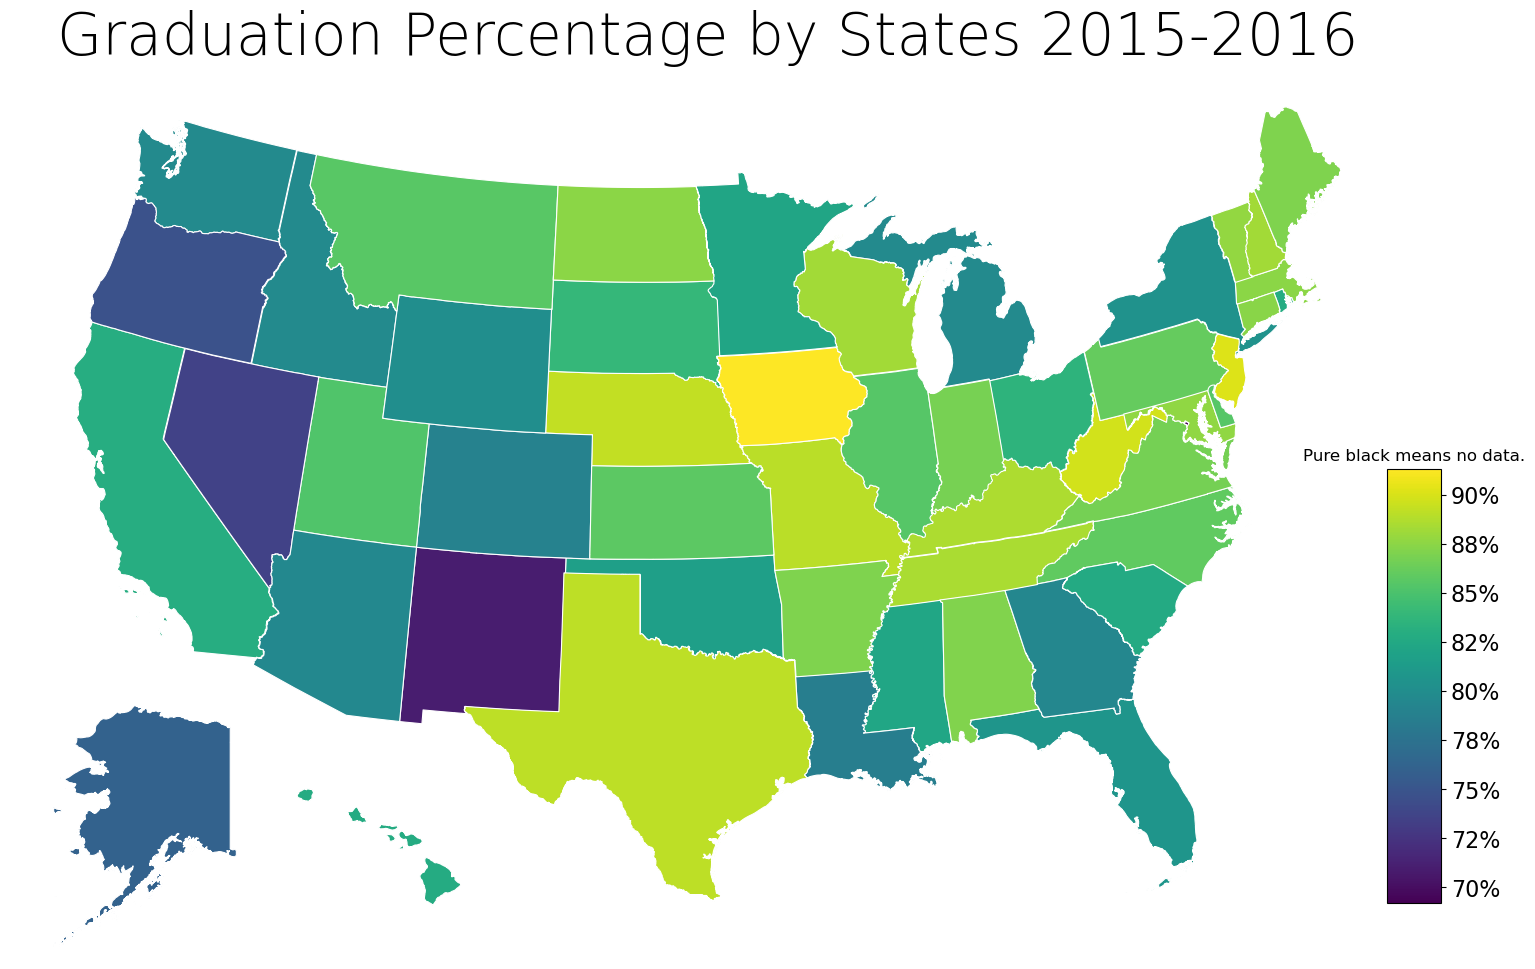

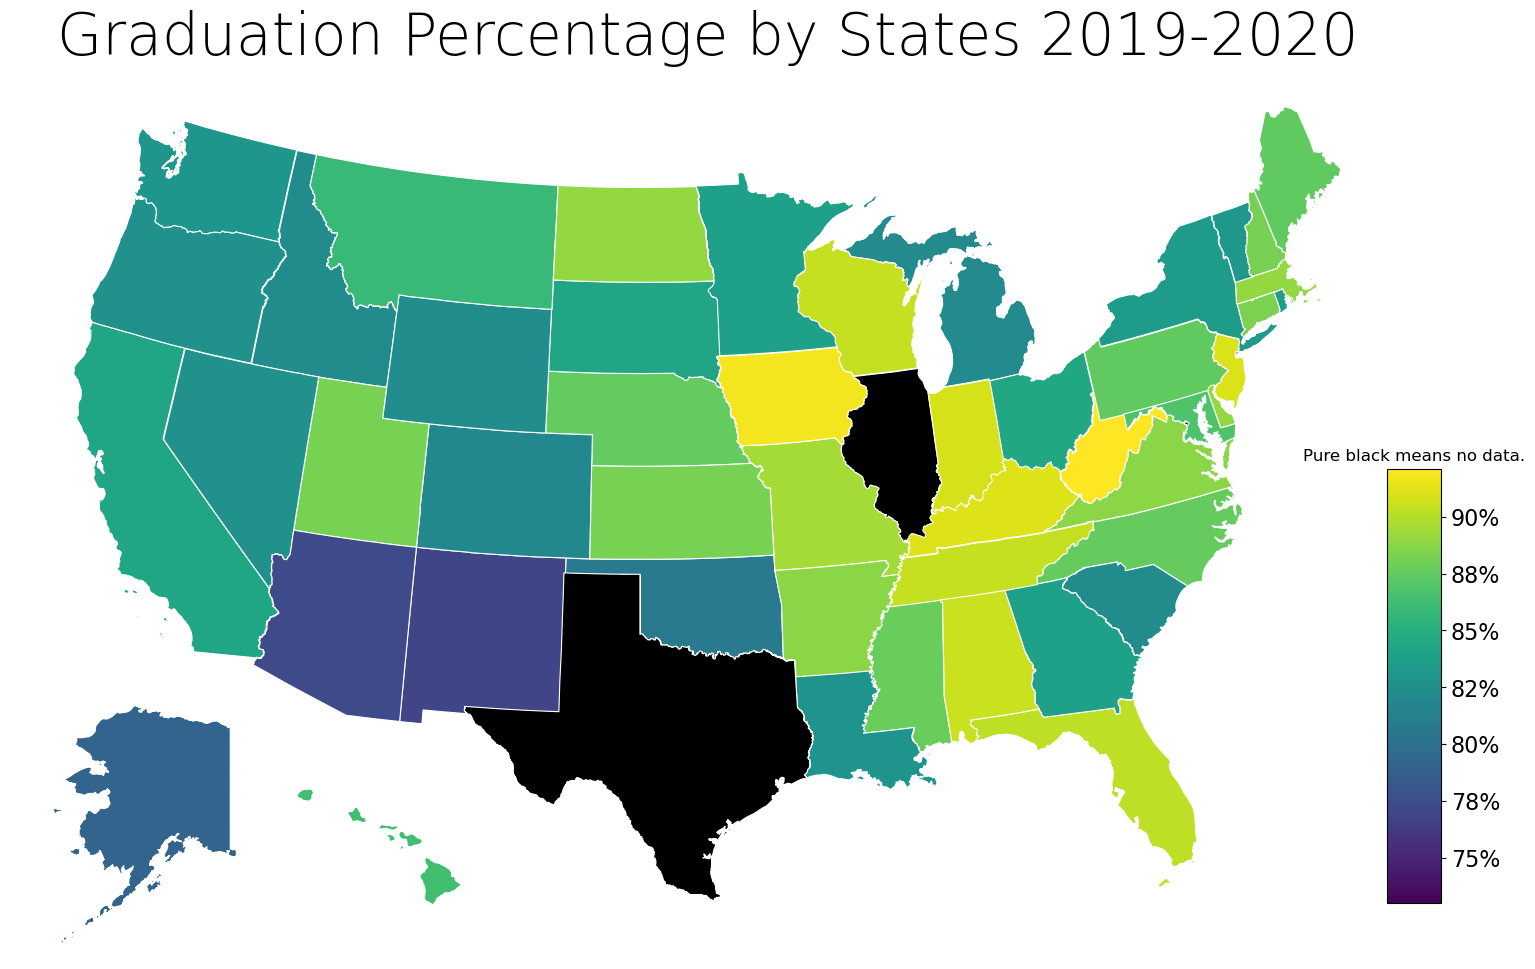

In [6]:
years = ['2011-\n12','2015-\n16','2019-\n20']
for year in years:
    gen_map(year, gdf)
    year = parse_year_string(year)
    plt.savefig(os.path.join('../output/GradPer',f'Graduation Percentage in {year}'))